# Project Introduction

This is the motivation and background for the project.

THIS IS THE OVERALL GOAL & DESIRED OUTCOME OF OUR PROJECT

This project explores the data from UCI Machine Learning posted up on Kaggle. 

https://www.kaggle.com/uciml/human-activity-recognition-with-smartphones/home

## Process Overview
1. Imports & Function Definitions
1. Ingest the Data
1. Exploratory Data Analysis
1. PCA with Visualization
1. GMM 
1. KMeans & KNN
1. Any other Models
1. Logistic Regression  
THESE MAY NOT BE NECESSARY IN THE NOTEBOOK. MORE FOR THE PRESENTATION
1. Comparison of Results
1. Conclusions
1. Recommendations and Next Steps

## Imports & Function Definitions

In [1]:
# Imports 
%matplotlib inline

# General Python libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import time
import random

# Feature Extraction & Unsupervised Libraries
from sklearn.feature_extraction.text import *
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM # Jason thinks we should delete this and anything else not used
from sklearn.mixture import GaussianMixture

from sklearn import preprocessing
from matplotlib.colors import LogNorm

# Learning/Model Libraries
from sklearn.pipeline import Pipeline # Jason thinks this isn't a model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV # Jason thinks this isn't a model
# Add trees libraries

# Evaluation Libarires
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
def show_confusion_mat(test_labels, predict_labels, target_names):
    size_val = len(target_names)
    
    # Calculate the confusion matrix
    result_confusion = confusion_matrix(test_labels, predict_labels, target_names)
    
    # Create a heat map version of the confusion matrix to print
    fig = plt.figure(figsize = (size_val, size_val))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(result_confusion, cmap = plt.get_cmap('PuRd'))
    target_values = np.arange(size_val)
    ax.set_xticks(target_values)
    ax.set_yticks(target_values)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top') 
    ax.set_xticklabels(target_names, rotation = 90)
    ax.set_yticklabels(target_names)
    # Loop over data dimensions and create text annotations.
    for x_ind in target_values:
        for y_ind in target_values:
            text = ax.text(y_ind, x_ind, result_confusion[x_ind, y_ind],
                       ha="center", va="center", color="k")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    fig.tight_layout()
    plt.show()

## Ingest the Data

In [3]:
target_names = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING']
group_names = ['DYNAMIC', 'STATIC']

# Read in the raw data, process and save into different folder
RAWDATA_PATH = '../data/raw/UCIHumanActivity/'
df_rtrain = pd.read_csv(f'{RAWDATA_PATH}train.csv')
all_columns = df_rtrain.columns
feature_columns = all_columns[0:561]
train_labels = df_rtrain['Activity'].values

train_group = ["DYNAMIC" if 'WALKING' in activity else "STATIC" for activity in train_labels]
train_data = df_rtrain[feature_columns].values

df_rtrain.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [23]:
# Load in and process test data
df_rtest = pd.read_csv(f'{RAWDATA_PATH}test.csv')
test_labels = df_rtest['Activity'].values
test_group = ["DYNAMIC" if 'WALKING' in activity else "STATIC" for activity in test_labels]
test_data = df_rtest[feature_columns].values

## Exploratory Data Analysis
### Basic characteristics of the raw training data

In [5]:
print("There are %d rows and %d columns in raw training data, with %d empty fields." 
      % (df_rtrain.shape[0], df_rtrain.shape[1], sum(df_rtrain.isnull().sum())))
print("\nDatatypes in raw training data, along with their counts, which do sum to the number of columns:")
print(df_rtrain.dtypes.value_counts())
print("\nColumn name and datatype for the last three columns in the raw training data:")
print(df_rtrain.dtypes[-3:])

There are 7352 rows and 563 columns in raw training data, with 0 empty fields.

Datatypes in raw training data, along with their counts, which do sum to the number of columns:
float64    561
int64        1
object       1
dtype: int64

Column name and datatype for the last three columns in the raw training data:
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
dtype: object


### Basic characteristics of the raw test data

In [6]:
print("There are %d rows and %d columns in raw test data, with %d empty fields." 
      % (df_rtest.shape[0], df_rtest.shape[1], sum(df_rtrain.isnull().sum())))
print("\nDatatypes in raw test data, along with their counts, which sum to the number of columns:")
print(df_rtest.dtypes.value_counts())
print("\nColumn name and datatype for the last three columns in the raw test data:")
print(df_rtest.dtypes[-3:])

There are 2947 rows and 563 columns in raw test data, with 0 empty fields.

Datatypes in raw test data, along with their counts, which sum to the number of columns:
float64    561
int64        1
object       1
dtype: int64

Column name and datatype for the last three columns in the raw test data:
angle(Z,gravityMean)    float64
subject                   int64
Activity                 object
dtype: object


### Assessing balance of subjects and activities in raw training and test data

In [7]:
print("There are %d subjects (participants) in the raw training data, identified by integers." 
      % (len(np.unique(df_rtrain['subject']))))
print("The number of examples per subject ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtrain['subject'].value_counts()), max(df_rtrain['subject'].value_counts()),
        max(df_rtrain['subject'].value_counts()) / min(df_rtrain['subject'].value_counts())))
print(df_rtrain['subject'].value_counts())
print("\nExamples in the raw training data are labeled with one of %d activities." 
      % (len(np.unique(df_rtrain['Activity']))))
print("The number of examples per activity ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtrain['Activity'].value_counts()), max(df_rtrain['Activity'].value_counts()),
        max(df_rtrain['Activity'].value_counts()) / min(df_rtrain['Activity'].value_counts())))
df_rtrain['Activity'].value_counts()

There are 21 subjects (participants) in the raw training data, identified by integers.
The number of examples per subject ranges from 281 to 409 (factor of 1.5) as follows:
25    409
21    408
26    392
30    383
28    382
27    376
23    372
17    368
16    366
19    360
1     347
29    344
3     341
15    328
6     325
14    323
22    321
11    316
7     308
5     302
8     281
Name: subject, dtype: int64

Examples in the raw training data are labeled with one of 6 activities.
The number of examples per activity ranges from 986 to 1407 (factor of 1.4) as follows:


LAYING                1407
STANDING              1374
SITTING               1286
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     986
Name: Activity, dtype: int64

In [8]:
print("There are %d subjects (participants) in the raw test data, identified by integers." 
      % (len(np.unique(df_rtest['subject']))))
print("The number of examples per subject ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtest['subject'].value_counts()), max(df_rtest['subject'].value_counts()),
        max(df_rtest['subject'].value_counts()) / min(df_rtest['subject'].value_counts())))
print(df_rtest['subject'].value_counts())
print("\nExamples in the raw test data are labeled with one of %d activities." 
      % (len(np.unique(df_rtest['Activity']))))
print("The number of examples per activity ranges from %d to %d (factor of %.1f) as follows:"
      % (min(df_rtest['Activity'].value_counts()), max(df_rtest['Activity'].value_counts()),
        max(df_rtest['Activity'].value_counts()) / min(df_rtest['Activity'].value_counts())))
df_rtest['Activity'].value_counts()

There are 9 subjects (participants) in the raw test data, identified by integers.
The number of examples per subject ranges from 288 to 381 (factor of 1.3) as follows:
24    381
18    364
20    354
13    327
12    320
4     317
2     302
10    294
9     288
Name: subject, dtype: int64

Examples in the raw test data are labeled with one of 6 activities.
The number of examples per activity ranges from 420 to 537 (factor of 1.3) as follows:


LAYING                537
STANDING              532
WALKING               496
SITTING               491
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
Name: Activity, dtype: int64

### Observations on basic characteristics of the raw training and test data
* There are 7352 examples in the training set, and 2947 examples in the test set.
* There are 563 columns in both data sets.
* Each example is labeled with one of 6 activities (Y) in the last column, represented as a text object.
* There are 21 subjects in the training set and 9 others in the test set, each identified by an integer.
* The datatype for all 561 other columns is float64.
* There are no NaN fields.
* Within each dataset, subjects and activities have balanced representation across examples.

### Evaluating skew in the raw training set
* According to the Kaggle website, the training/test split was based on randomly-selected subjects. We'll assume for now that this is true (appears so), such that skew in training set reflects skew in test set. 

The following histograms suggest that range of values for a given feature is not always from -1 to 1.
Skew appears to be generally positive.


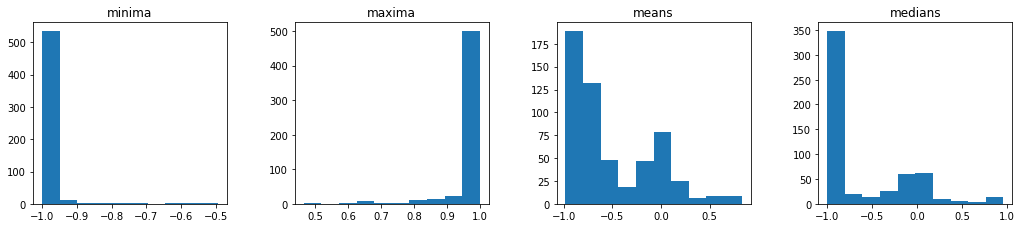

In [9]:
print("The following histograms suggest that range of values for a given feature is not always from -1 to 1.")
print("Skew appears to be generally positive.")
# https://blog.stata.com/2016/12/13/understanding-truncation-and-censoring/
exclude = ['Activity', 'subject']
mins = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].min()
mens = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].mean()
meds = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].median()
maxs = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)].max()
df = pd.DataFrame({'minima':mins, 'means':mens, 'medians':meds, 'maxima':maxs})
headers = ['minima','maxima','means','medians']
plt.figure(num=None, figsize=(16,3))
for i in range(0,df.shape[1]):
    plt.subplot(1,4,i+1)
    plt.hist(df[headers[i]])
    plt.title(headers[i])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

A random sampling of features suggests there is also some censoring and/or truncation.
(In addition to the generally positive skew.)


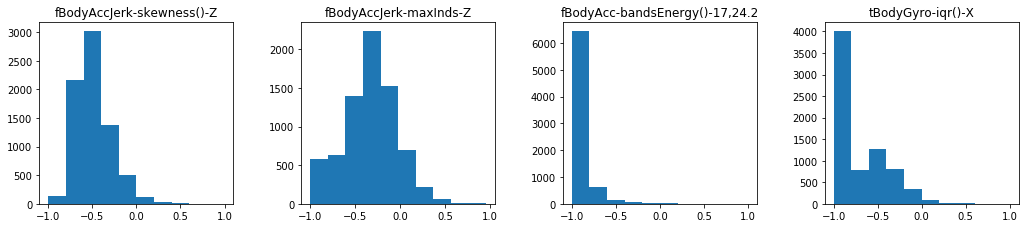

In [10]:
print("A random sampling of features suggests there is also some censoring and/or truncation.")
print("(In addition to the generally positive skew.)")
plt.figure(num=None, figsize=(16,3))
rand_list = random.sample(range(0,561),4)
for i in range(0,len(rand_list)):
    plt.subplot(1,4,i+1)
    plt.hist(df_rtrain[df_rtrain.columns[rand_list[i]]])
    plt.title(df_rtrain.columns[rand_list[i]])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

## PCA & Visualization of Features
* Annie recommends pulling from Jason's and Matt's (like the plots on the feature value)

### Evaluating the potential for data compression
* 561 features (temporarily excluding the 'subject' column) is a lot to manage

Even with no feature scaling, only 5 PCA components are needed to explain 75% of total variance.
Scaling to a range from 0 to 1 does not affect portion of total variance explained.
In contrast, standardizing to zero mean and unity variance worsens compression.


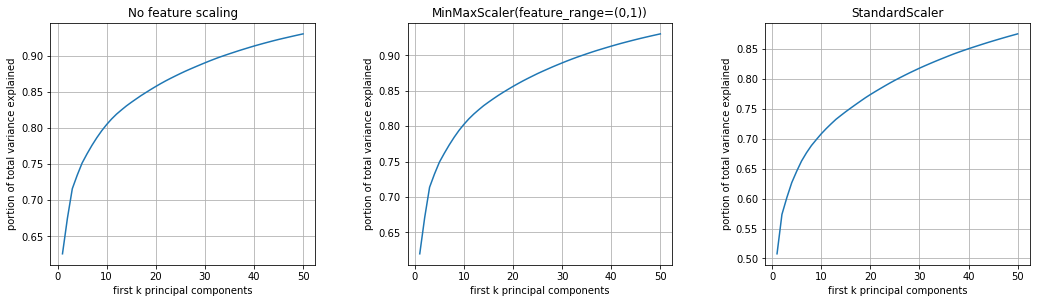

In [11]:
def first_k(k_range, pca):
    first_k = []
    for k in k_range:
        if k == 1:
            first_k.extend([pca.explained_variance_ratio_[k-1]])
        else:
            first_k.extend(first_k[k-2]+[pca.explained_variance_ratio_[k-1]])
    return first_k

exclude = ['Activity', 'subject']
k_range = list(range(1,51))

plt.figure(num=None, figsize=(16,4))

rtrain_ns = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)]
pca_ns = PCA(n_components=len(k_range))
pca_ns.fit(rtrain_ns)
plt.subplot(1,3,1)
plt.plot(k_range, first_k(k_range,pca_ns), label=df_rtrain['Activity'])
plt.title('No feature scaling')
plt.xlabel('first k principal components')
plt.ylabel('portion of total variance explained')
plt.grid(True)

rtrain_mms = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)]
mm_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
rtrain_mms = mm_scaler.fit_transform(rtrain_mms)
pca_mms = PCA(n_components=len(k_range))
pca_mms.fit(rtrain_mms)
plt.subplot(1,3,2)
plt.plot(k_range, first_k(k_range,pca_mms), label=df_rtrain['Activity'])
plt.title('MinMaxScaler(feature_range=(0,1))')
plt.xlabel('first k principal components')
plt.ylabel('portion of total variance explained')
plt.grid(True)

rtrain_sts = df_rtrain.loc[:, df_rtrain.columns.difference(exclude)]
st_scaler = preprocessing.StandardScaler()
rtrain_sts = st_scaler.fit_transform(rtrain_sts)
pca_sts = PCA(n_components=len(k_range))
pca_sts.fit(rtrain_sts)
plt.subplot(1,3,3)
plt.plot(k_range, first_k(k_range,pca_sts), label=df_rtrain['Activity'])
plt.title('StandardScaler')
plt.xlabel('first k principal components')
plt.ylabel('portion of total variance explained')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
print("Even with no feature scaling, only 5 PCA components are needed to explain 75% of total variance.")
print("Scaling to a range from 0 to 1 does not affect portion of total variance explained.")
print("In contrast, standardizing to zero mean and unity variance worsens compression.")
plt.show()

### Visualizing the effect of 2-component PCA

Using MinMaxScaler and 2-component PCA, the examples are visibly split into two superclusters.
The first supercluster is comprised of stationary activities: laying, sitting, standing.
The second supercluster is comprised of dynamic activities: walking, walking downstairs, walking upstairs.
Whereas the stationary activities greatly overlap, dynamic activities are somewhat differentiated.
This suggests more than 2 PCA components may be needed to differentiate all activities.


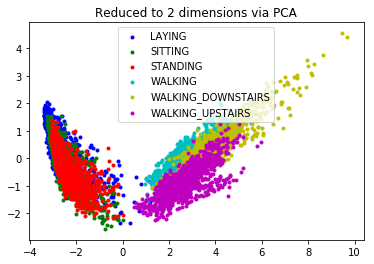

In [12]:
pca = PCA(n_components=2)
dim_reduc = pca.fit_transform(rtrain_mms) 
label_set = np.unique(df_rtrain['Activity'])
color_set = ['b', 'g', 'r', 'c', 'y', 'm']
plt.figure()
for i in range(0,len(label_set)):
    plt.scatter(dim_reduc[df_rtrain['Activity'] == label_set[i], 0], 
                dim_reduc[df_rtrain['Activity'] == label_set[i], 1], 
                color=color_set[i], marker='.', label=label_set[i])
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Reduced to 2 dimensions via PCA')
print("Using MinMaxScaler and 2-component PCA, the examples are visibly split into two superclusters.")
print("The first supercluster is comprised of stationary activities: laying, sitting, standing.")
print("The second supercluster is comprised of dynamic activities: walking, walking downstairs, walking upstairs.")
print("Whereas the stationary activities greatly overlap, dynamic activities are somewhat differentiated.")
print("This suggests more than 2 PCA components may be needed to differentiate all activities.")
plt.show()

Plots for each subject show that differentiation between activities is cleaner for some subjects.
For example, walking downstairs and upstairs seem indistinguishable for subject 22.
In contrast, walking downstiairs and upstairs are fairly distinct for subject 11.


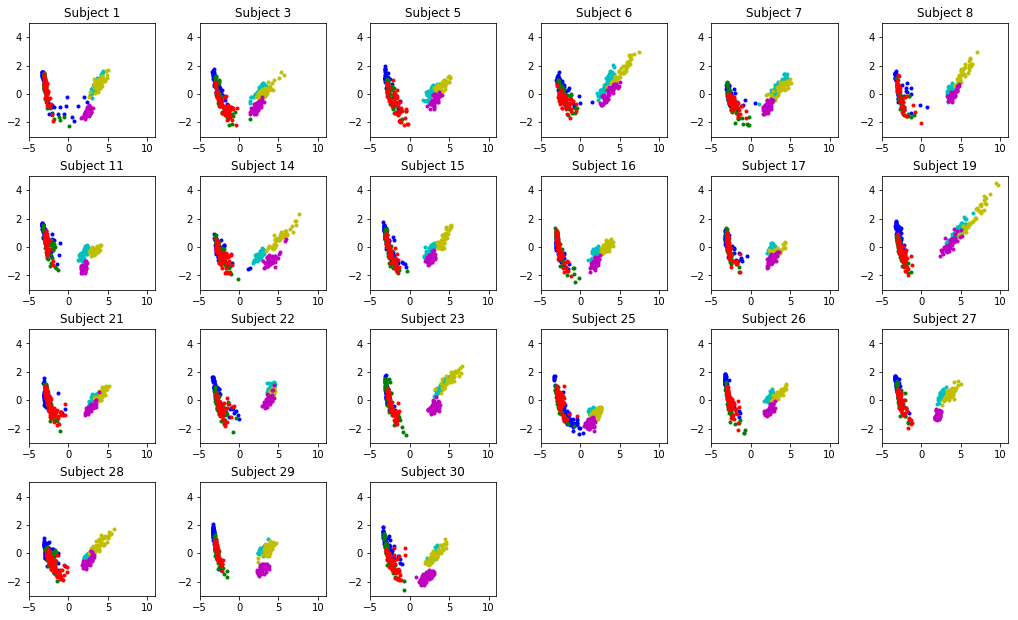

In [13]:
pca = PCA(n_components=2)
dim_reduc = pca.fit_transform(rtrain_mms) 
subject_set = np.unique(df_rtrain['subject'])
label_set = np.unique(df_rtrain['Activity'])
color_set = ['b', 'g', 'r', 'c', 'y', 'm']
plt.figure(num=None, figsize=(16,12))
for h in range(0,len(subject_set)):
    plt.subplot(5,6,h+1)
    for i in range(0,len(label_set)):
        plt.scatter(dim_reduc[(df_rtrain['Activity'] == label_set[i]) & (df_rtrain['subject'] == subject_set[h]), 0], 
                    dim_reduc[(df_rtrain['Activity'] == label_set[i]) & (df_rtrain['subject'] == subject_set[h]), 1], 
                    color=color_set[i], marker='.', label=label_set[i])
    #plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('Subject %d' % subject_set[h])
    plt.axis([-5,11,-3,5])
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35, wspace=0.35)
print("Plots for each subject show that differentiation between activities is cleaner for some subjects.")
print("For example, walking downstairs and upstairs seem indistinguishable for subject 22.")
print("In contrast, walking downstiairs and upstairs are fairly distinct for subject 11.")
plt.show()

## Gaussian Mixture Models
### Repartitioning (still by subject) to generate a dev set
* Subjects were already cleanly separated in the raw training and test sets (e.g., subject 1 is in train not test).
* Subjects will remain cleanly separated in this first train/dev/test split. 

In [21]:
df_rcomb = pd.concat([df_rtrain, df_rtest]).sample(frac=1).reset_index(drop=True)

unsubs = np.unique(df_rcomb['subject'])
# # tried mapping categorical subject feature to binary features
# # realized this would be better for logistic regression...
# d = dict((unsub, np.array(df_rcomb['subject'] == unsub).astype(int)) for unsub in unsubs)
# df = pd.DataFrame(data=d)
# df_rcomb = df_rcomb.join(df)
# # verifying all went well
# diffs = []
# for unsub in unsubs:
#     diffs.extend([df_rcomb[unsub]*unsub == df_rcomb['subject']])
# print(sum(np.array(diffs).flat))
# print(df_rcomb.shape)

dev_sub_count = 6
test_sub_count = 6
sub_dtsplit = len(unsubs) - test_sub_count
sub_tdsplit = sub_dtsplit - dev_sub_count
shuffled = np.random.permutation(unsubs)
train_subs = shuffled[:sub_tdsplit]
dev_subs = shuffled[sub_tdsplit:sub_dtsplit]
test_subs = shuffled[sub_dtsplit:]
print("Subjects included in train set:", np.sort(train_subs))
print("Subjects included in dev set:", np.sort(dev_subs))
print("Subjects included in test set:", np.sort(test_subs))

exclude = ['Activity', 'subject']
df_ptrain = df_rcomb.loc[df_rcomb['subject'].isin(train_subs)]
df_ptrainf = df_ptrain.loc[:, df_ptrain.columns.difference(exclude)]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
df_ptrainf = scaler.fit_transform(df_ptrainf)
df_pdev = df_rcomb.loc[df_rcomb['subject'].isin(dev_subs)]
df_pdevf = df_pdev.loc[:, df_pdev.columns.difference(exclude)]
df_pdevf = scaler.transform(df_pdevf)
df_ptest = df_rcomb.loc[df_rcomb['subject'].isin(test_subs)]
df_ptestf = df_ptest.loc[:, df_ptest.columns.difference(exclude)]
df_ptestf = scaler.transform(df_ptestf)
print("Train set shape:", df_ptrain.shape)
print("Dev set shape:", df_pdev.shape)
print("Test set shape:", df_ptest.shape)

Subjects included in train set: [ 2  3  4  7  8  9 10 12 13 14 19 21 22 24 25 26 27 28]
Subjects included in dev set: [ 5 11 17 18 29 30]
Subjects included in test set: [ 1  6 15 16 20 23]
Train set shape: (6130, 563)
Dev set shape: (2077, 563)
Test set shape: (2092, 563)


## Evaluating accuracy of 6-component GMMs with multicomponent PCA
* Also varying covariance type GMM hyperparameter. 

Accuracy varies somewhat between runs due to random initilization.
Reasonably close agreement in accuracy against dev and test suggests overfitting isn't excessive.


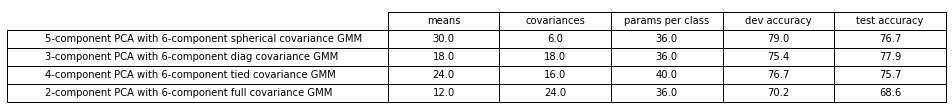

In [22]:
def experiment(pca_comp, gmm_comp, cov_type):
    pca = PCA(n_components=pca_comp)
    pca.fit(df_ptrainf) 
    dim_reduc = pca.transform(df_ptrainf) 
    gmm = []
    lp_dev = []
    lp_test = []
    label_set = np.unique(df_ptrain['Activity'])
    for i in range(0,len(label_set)):
        one_label = dim_reduc[df_ptrain['Activity'] == label_set[i]]
        gmm.extend([GaussianMixture(n_components=gmm_comp, covariance_type=cov_type)])
        gmm[i].fit(one_label)
        lp_dev.extend([gmm[i].score_samples(pca.transform(df_pdevf))]) # weighted log probabilities
        lp_test.extend([gmm[i].score_samples(pca.transform(df_ptestf))]) 
    pred_dev = []
    pred_test = []
    for j in range(0,lp_dev[0].shape[0]):
        col = [row[j] for row in lp_dev]
        pred_dev.extend([label_set[np.argmax(col)]])
    for j in range(0,lp_test[0].shape[0]):
        col = [row[j] for row in lp_test]
        pred_test.extend([label_set[np.argmax(col)]]) 
    means = gmm[0].means_.size
    covs = gmm[0].covariances_.size
    ppc = means + covs # parameters per class
    dev_acc = round(metrics.accuracy_score(df_pdev['Activity'],pred_dev)*100,1)
    test_acc = round(metrics.accuracy_score(df_ptest['Activity'],pred_test)*100,1)
    tab_cells.append([means, covs, ppc, dev_acc, test_acc])
    tab_rows.extend(["%d-component PCA with %d-component %s covariance GMM" 
                     % (pca_comp, gmm_comp, cov_type)])

tab_cols = ['means', 'covariances', 'params per class', 'dev accuracy', 'test accuracy']
tab_rows = []
tab_cells = []
ppc_lim = 50 # arbitrary limit on parameters per class
covs = ['spherical', 'diag', 'tied', 'full'] 

gmm_comp = np.unique(df_ptrain['Activity']).shape[0] # setting to class count for simplicity
for cov in covs:
    if cov == 'spherical':
        pca_comp = 5 # each component has its own single variance
    elif cov == 'diag':
        pca_comp = 3 # each component has its own diagonal covariance matrix
    elif cov == 'tied':
        pca_comp = 4 # all components share the same general covariance matrix
    elif cov == 'full':
        pca_comp = 2 # each component has its own general covariance matrix
    else:
        print("error: bad cov")
    if gmm_comp > 0:
        experiment(pca_comp, gmm_comp, cov)
            
tab_cells = np.array(tab_cells)
print("Accuracy varies somewhat between runs due to random initilization.")
print("Reasonably close agreement in accuracy against dev and test suggests overfitting isn't excessive.")

plt.figure(figsize=(10, 1)) 
tab = plt.table(cellText=tab_cells,rowLabels=tab_rows, colLabels=tab_cols, 
                cellLoc='center', loc='upper left')
for key, cell in tab.get_celld().items():
    row, col = key
plt.axis('off')
tab.scale(xscale=1, yscale=1.5) # for row spacing relative to text
plt.show()

## KMeans and KNN

In [ ]:
# From Matt

## Other Models

In [ ]:
# If anyone is feeling ambitious...

## Logistic Regression

In [ ]:
# This is Annie's stuff - Annie will parse this down to simplify 

In [21]:
model_log = LogisticRegression()
model_log.fit(train_data, train_labels)
predict_labels = model_log.predict(test_data)
        
# Calculate metrics
#accuracy = sum(train_labels == predict_labels) / len(test_labels)
f1_score = metrics.f1_score(test_labels, predict_labels, average = 'weighted')

#print(accuracy)
print(f1_score)

0.9618652634530593


In [44]:
parameters = {'penalty':('l1', 'l2'), 'C': [0.001, 0.01, 0.1, 0.5, 0.9, 1, 1.25,  2, 5, 10]}
#[0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99, 1, 1.25, 1.5, 2, 5, 10, 50, 100, 500, 1000]}
model_log = LogisticRegression()
search_model = GridSearchCV(model_log, parameters)
search_model.fit(train_data, train_labels)

output = search_model.cv_results_ 
output

/Users/annielane/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/annielane/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/annielane/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/annielane/anac

{'mean_fit_time': array([0.99248608, 1.54560741, 1.0301586 , 1.93952719, 1.637954  ,
        2.66262142, 2.57885615, 3.14195434, 2.96348405, 3.22251042,
        3.10463929, 3.26611757, 3.31835238, 3.34512575, 3.81967409,
        3.43885859, 5.41948533, 3.83819636, 7.48455429, 4.09050226]),
 'mean_score_time': array([0.00888364, 0.00750891, 0.00564138, 0.00622416, 0.00603541,
        0.00567619, 0.00662978, 0.00656939, 0.00562835, 0.00587757,
        0.00580128, 0.0069193 , 0.006253  , 0.0069646 , 0.00558329,
        0.00627605, 0.00555634, 0.00565902, 0.0058322 , 0.00579826]),
 'mean_test_score': array([0.61275843, 0.87214363, 0.85595756, 0.90451578, 0.92437432,
        0.93226333, 0.94164853, 0.93920022, 0.94368879, 0.94164853,
        0.94328074, 0.9413765 , 0.94396083, 0.9421926 , 0.94368879,
        0.94260065, 0.94314472, 0.9445049 , 0.94368879, 0.94477693]),
 'mean_train_score': array([0.63404779, 0.89594938, 0.87894719, 0.9458671 , 0.97157423,
        0.98109371, 0.99047908, 0.9

In [45]:
search_model.best_estimator_

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [46]:
search_model.best_score_

0.9447769314472253

F1-Score: 0.9621619913278492
Accuracy: 0.9623345775364778
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       537
  WALKING_UPSTAIRS       0.97      0.87      0.92       491
WALKING_DOWNSTAIRS       0.90      0.98      0.94       532
           SITTING       0.95      1.00      0.97       496
          STANDING       1.00      0.97      0.98       420
            LAYING       0.98      0.95      0.96       471

       avg / total       0.96      0.96      0.96      2947



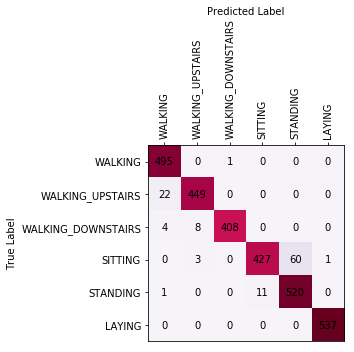

In [48]:
model_log = LogisticRegression(C=10)
model_log.fit(train_data, train_labels)
predict_labels = model_log.predict(test_data)
        
# Calculate metrics
f1_score = metrics.f1_score(test_labels, predict_labels, average = 'weighted')
print(f'F1-Score: {f1_score}')

accuracy = metrics.accuracy_score(test_labels, predict_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(test_labels, predict_labels, target_names = target_names))
show_confusion_mat(test_labels, predict_labels, target_names)

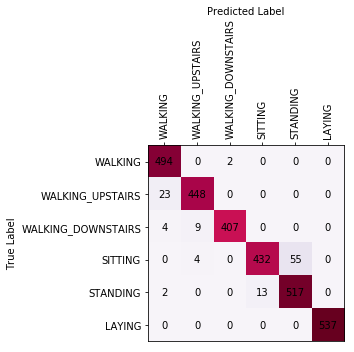

In [42]:
show_confusion_mat(test_labels, predict_labels, target_names)

In [24]:
print(classification_report(test_labels, predict_labels, target_names = target_names))

                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       537
          STANDING       0.97      0.88      0.92       491
  WALKING_UPSTAIRS       0.90      0.97      0.94       532
            LAYING       0.94      1.00      0.97       496
WALKING_DOWNSTAIRS       1.00      0.97      0.98       420
           SITTING       0.97      0.95      0.96       471

       avg / total       0.96      0.96      0.96      2947



In [32]:
accuracy = metrics.accuracy_score(test_labels, predict_labels)
print(accuracy)

0.9619952494061758


In [33]:
coefs = model_log.coef_
coefs

array([[-0.0899107 ,  0.00292006,  0.05290771, ...,  1.6327808 ,
        -0.37972022, -0.19304005],
       [-0.00996507, -0.04925666, -0.15132713, ..., -1.85269501,
        -1.94880426, -0.18321026],
       [ 0.0348283 ,  0.10065145,  0.18836939, ..., -1.16659207,
         2.17465635,  0.2145819 ],
       [-0.15111739, -0.06683331,  0.0980256 , ..., -0.33704903,
        -0.20862679,  0.06830182],
       [ 0.62796552,  0.14861174,  0.24044961, ..., -0.66722133,
        -0.37122092, -0.09816689],
       [-0.31900151, -0.33912766, -0.39835301, ...,  0.53861799,
         1.00996958,  0.43898122]])

### Comments and Next Steps 

## Binary Classification - Dynamic vs. Static

F1-Score: 1.0
Accuracy: 1.0
             precision    recall  f1-score   support

    DYNAMIC       1.00      1.00      1.00      1387
     STATIC       1.00      1.00      1.00      1560

avg / total       1.00      1.00      1.00      2947



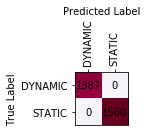

In [79]:
model_log = LogisticRegression()
model_log.fit(train_data, train_group)
predict_labels = model_log.predict(test_data)
        
# Calculate metrics
f1_score = metrics.f1_score(test_group, predict_labels, average = 'weighted')
print(f'F1-Score: {f1_score}')

accuracy = metrics.accuracy_score(test_group, predict_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(test_group, predict_labels, target_names = group_names))
show_confusion_mat(test_group, predict_labels, group_names)

In [105]:
coefs = model_log.coef_
sort_val_coefs = np.sort(coefs)
for val in np.flip(sort_val_coefs[0, -10:], axis = 0):
    print(val)
sort_ind_coefs = np.argsort(coefs)
sort_contribute = all_columns[sort_ind_coefs]
for contrib in np.flip(sort_contribute[0, -10:], axis = 0):
    print(contrib)

0.6486409467940233
0.40066959474697583
0.3632641235060091
0.3574173907846297
0.2980679342716545
0.2839036673894364
0.2740198548311795
0.2726407545810181
0.26693554691019733
0.26504097427806517
tGravityAcc-entropy()-Y
fBodyAccMag-kurtosis()
fBodyAccJerk-maxInds-X
fBodyAccMag-skewness()
tGravityAcc-max()-Y
tGravityAcc-energy()-Y
tGravityAcc-mean()-Y
angle(X,gravityMean)
tGravityAcc-iqr()-Z
tGravityAcc-std()-Z


(array([  4.,   5.,  14.,  35.,  60.,  90., 152., 138.,  35.,  17.,   7.,
          3.,   0.,   0.,   1.]),
 array([-0.51210456, -0.43472152, -0.35733849, -0.27995546, -0.20257242,
        -0.12518939, -0.04780635,  0.02957668,  0.10695971,  0.18434275,
         0.26172578,  0.33910881,  0.41649185,  0.49387488,  0.57125791,
         0.64864095]),
 <a list of 15 Patch objects>)

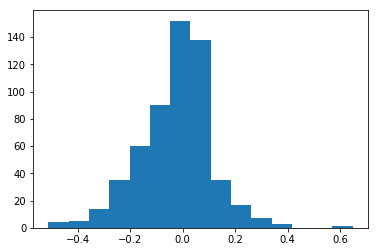

In [92]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.hist(coefs[0,:], bins = 15)

# 2 Component PCA 

/Users/annielane/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/annielane/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


F1-Score: 0.5460981759907311
Accuracy: 0.5972175093315236
                    precision    recall  f1-score   support

           WALKING       0.48      0.70      0.57       537
  WALKING_UPSTAIRS       0.00      0.00      0.00       491
WALKING_DOWNSTAIRS       0.48      0.69      0.57       532
           SITTING       0.66      0.80      0.72       496
          STANDING       0.67      0.49      0.57       420
            LAYING       0.84      0.87      0.86       471

       avg / total       0.52      0.60      0.55      2947



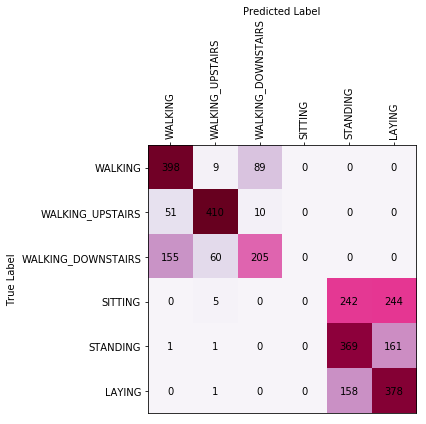

In [65]:
pca = PCA(2)
train_pca_data = pca.fit_transform(train_data)
test_pca_data = pca.transform(test_data)


model_log = LogisticRegression()
model_log.fit(train_pca_data, train_labels)
predict_labels = model_log.predict(test_pca_data)
        
# Calculate metrics
f1_score = metrics.f1_score(test_labels, predict_labels, average = 'weighted')
print(f'F1-Score: {f1_score}')

accuracy = metrics.accuracy_score(test_labels, predict_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(test_labels, predict_labels, target_names = target_names))
show_confusion_mat(test_labels, predict_labels, target_names)

## 100 Component PCA

F1-Score: 0.9502167393483999
Accuracy: 0.9504580929759077
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       537
  WALKING_UPSTAIRS       0.94      0.85      0.89       491
WALKING_DOWNSTAIRS       0.88      0.95      0.92       532
           SITTING       0.94      1.00      0.96       496
          STANDING       0.99      0.97      0.98       420
            LAYING       0.97      0.93      0.95       471

       avg / total       0.95      0.95      0.95      2947



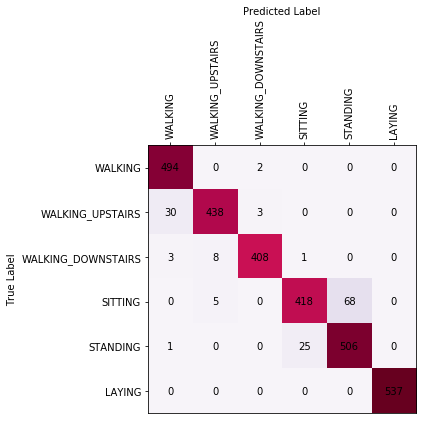

In [66]:
pca = PCA(100)
train_pca_data = pca.fit_transform(train_data)
test_pca_data = pca.transform(test_data)


model_log = LogisticRegression()
model_log.fit(train_pca_data, train_labels)
predict_labels = model_log.predict(test_pca_data)
        
# Calculate metrics
f1_score = metrics.f1_score(test_labels, predict_labels, average = 'weighted')
print(f'F1-Score: {f1_score}')

accuracy = metrics.accuracy_score(test_labels, predict_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(test_labels, predict_labels, target_names = target_names))
show_confusion_mat(test_labels, predict_labels, target_names)

## 10 Component PCA

F1-Score: 0.8640719158062342
Accuracy: 0.8649474041398032
                    precision    recall  f1-score   support

           WALKING       1.00      0.99      0.99       537
  WALKING_UPSTAIRS       0.79      0.75      0.77       491
WALKING_DOWNSTAIRS       0.79      0.82      0.81       532
           SITTING       0.84      0.97      0.90       496
          STANDING       0.90      0.78      0.83       420
            LAYING       0.88      0.86      0.87       471

       avg / total       0.87      0.86      0.86      2947



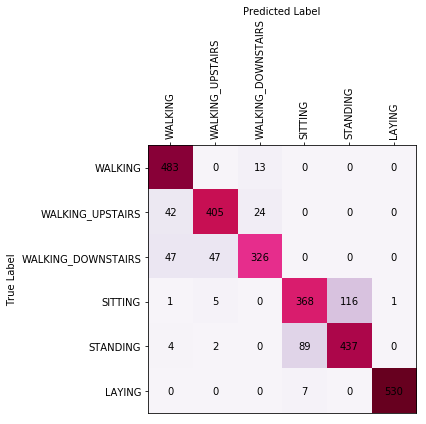

In [106]:
pca = PCA(10)
train_pca_data = pca.fit_transform(train_data)
test_pca_data = pca.transform(test_data)


model_log = LogisticRegression()
model_log.fit(train_pca_data, train_labels)
predict_labels = model_log.predict(test_pca_data)
        
# Calculate metrics
f1_score = metrics.f1_score(test_labels, predict_labels, average = 'weighted')
print(f'F1-Score: {f1_score}')

accuracy = metrics.accuracy_score(test_labels, predict_labels)
print(f'Accuracy: {accuracy}')

print(classification_report(test_labels, predict_labels, target_names = target_names))
show_confusion_mat(test_labels, predict_labels, target_names)

## Create a search over the space

AttributeError: 'str' object has no attribute 'shape'

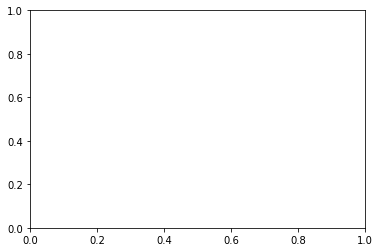

In [78]:
#fig = plt.figure()
#ax = fig.add_subplot(1, 1, 1)

train_cat = df_rtrain['Activity'].astype('category')
df_pca = pd.DataFrame({'x' : train_pca_data[:,0],
                       'y' : train_pca_data[:,1],
                       'cat' : train_cat
})
df_pca.plot.scatter('x', 'y', c='cat')

#plt.scatter(train_pca_data[:,0],train_pca_data[:,1], c = train_cat)


In [71]:
train_cat[0:10]

0    STANDING
1    STANDING
2    STANDING
3    STANDING
4    STANDING
5    STANDING
6    STANDING
7    STANDING
8    STANDING
9    STANDING
Name: Activity, dtype: category
Categories (6, object): [LAYING, SITTING, STANDING, WALKING, WALKING_DOWNSTAIRS, WALKING_UPSTAIRS]

# Look at only Frequency Domain 

In [108]:
freq_columns = [col if re.match('^f', col) for col in feature_columns]
len(freq_columns)

SyntaxError: invalid syntax (<ipython-input-108-331333ffda63>, line 1)